# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from scipy.spatial.distance import cdist
import os
from itertools import combinations
from tqdm import tqdm

In [6]:
# function for loading the training data:

def load_data(file):
    """
    This function loads the data from the specified pickle file and returns a dictionary with the data
    :param filename: the pickle file
    :return: dict with data -- keys and values differ for the train data and test data for each task.
     Please see the cells with example code below for explanations and examples of the data structure per data set.
    """
    with open(file, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

In [7]:
train_data = load_data('train_data.pkl')

In [8]:
# the structure of the training data is a dict, where the keys are strings indicating the alphabet.
# The values are again dicts, with the keys being the character and the values being a list of images of that character.

# see the code below for examples of working with the train data

alphabets = list(train_data.keys())


print('example alphabet names:', alphabets[:5])
print('\n')
print('how to get an example image for a specific character:')

alphabet_id = 4
alphabet = alphabets[alphabet_id]  # a dict
characters_for_this_alphabet = list(train_data[alphabet].keys())
character_id = 5
character = characters_for_this_alphabet[character_id]
image_id = 2

print(f'shape of image {image_id} of character {character} of alphabet {alphabet}:', train_data[alphabet][character][image_id].shape)

example alphabet names: ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)']


how to get an example image for a specific character:
shape of image 2 of character character06 of alphabet Asomtavruli_(Georgian): torch.Size([1, 105, 105])


In [9]:
# function for plotting some examples:

def plot_example_data(data_dict):
    """
    This function plots some examples of the data
    :param data_dict: dict with as keys a string specifying the alphabet, and as values a dict with as keys the character of the alphabet, and as values a list om images of the alphabet
    """
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    alphabets_to_plot = np.random.choice(list(data_dict.keys()), size=10, replace=False)
    
    for i, alphabet in enumerate(alphabets_to_plot):
        characters = data_dict[alphabet]
        character_to_plot = np.random.choice(list(characters.keys()), size=1)[0]
        images = characters[character_to_plot]
        im_idx = np.random.choice(len(images), size=1)[0]
        axs[i//5, i%5].imshow(images[im_idx].permute(1, 2, 0))
        axs[i//5, i%5].set_title(alphabet + '\n' + character_to_plot, fontsize=8)
        axs[i//5, i%5].axis('off')
    # plt.show()


<Figure size 432x288 with 0 Axes>

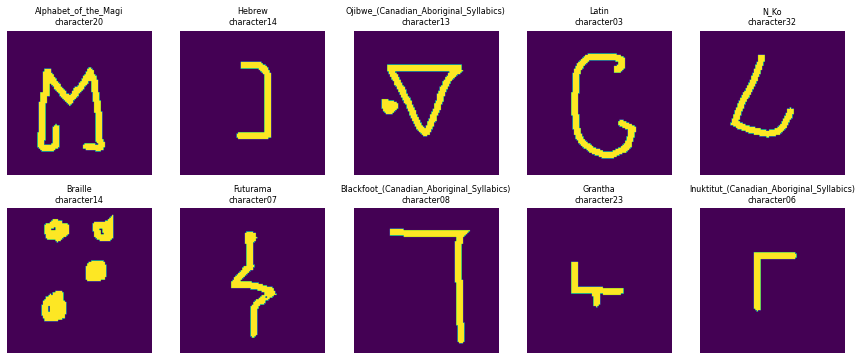

In [10]:
plt.figure()
plot_example_data(train_data)
# plt.savefig('example_data.png', dpi=600)
plt.show()

# Task 1: character recognition

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


class EmbeddingNet(nn.Module):
    def __init__(self):
        """CNN Builder."""
        super(EmbeddingNet, self).__init__()

        self.front_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Lambda(lambda x: x.view(x.size(0), -1)),

            nn.Linear(256 * 13 * 13, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
        )

        self.last_layer = nn.Linear(512, 10)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)

In [12]:
class EmbeddingNet2(nn.Module):
    def __init__(self):
        """CNN Builder."""
        super(EmbeddingNet2, self).__init__()

        self.convolutional_layers = nn.Sequential(
            # Convolutional Block 1
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolutional Block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolutional Block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolutional Block 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            #nn.MaxPool2d(kernel_size=2, stride=2),

            # Flatten
            Lambda(lambda x: x.view(x.size(0), -1)),
        )

        self.output_layer = nn.Linear(13*13*512, 1024)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.convolutional_layers(x)
        x = self.output_layer(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)

In [13]:
from torch.utils.data.sampler import BatchSampler
import numpy as np
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size <= self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [14]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()


        anchor_idx= triplets[:, 0]
        positive_idx= triplets[:, 1]
        negative_idx= triplets[:, 2]


        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)
        print(losses)
        return losses.mean()

In [15]:
char_dict = {f"character{i:02d}": i - 1 for i in range(1, 100)}
train_loader_dict = {}
# Iterate over the dictionary items (label: images_list)
for alphabet in alphabets:
    data_alphabet = train_data[alphabet]
    image_label_list = []
    targets = []
    for label, images in data_alphabet.items():
        # Append each image-label pair as a tuple to the list
        for image in images:
            targets.append(char_dict[label])
            image_label_list.append((image, char_dict[label]))
    #print(len(targets)/len(set(targets)))
    train_batch_sampler = BalancedBatchSampler(targets, n_classes=len(set(targets)), n_samples=3)
    triplets_train_loader = torch.utils.data.DataLoader(image_label_list, batch_sampler=train_batch_sampler)
    train_loader_dict[alphabet] = triplets_train_loader



In [16]:
print(len(train_loader_dict['Latin']))
i=0
for batch_idx, (inputs, targets) in enumerate(train_loader_dict['Latin']):
    print(f"Batch {batch_idx}:")
    print("Inputs (features):")
    print(type(inputs))
    print(len(targets))  # Print input data (features)
    print("Targets (labels):")
    print(targets)
    i+=1
print(i)



6
Batch 0:
Inputs (features):
<class 'torch.Tensor'>
78
Targets (labels):
tensor([ 9,  9,  9,  2,  2,  2, 10, 10, 10, 12, 12, 12, 16, 16, 16, 22, 22, 22,
         6,  6,  6, 15, 15, 15,  5,  5,  5, 23, 23, 23,  8,  8,  8, 13, 13, 13,
        11, 11, 11, 21, 21, 21, 17, 17, 17,  7,  7,  7, 20, 20, 20, 14, 14, 14,
         3,  3,  3,  1,  1,  1, 24, 24, 24, 19, 19, 19, 18, 18, 18,  0,  0,  0,
        25, 25, 25,  4,  4,  4])
Batch 1:
Inputs (features):
<class 'torch.Tensor'>
78
Targets (labels):
tensor([ 5,  5,  5, 16, 16, 16,  1,  1,  1, 20, 20, 20, 25, 25, 25,  8,  8,  8,
         0,  0,  0, 17, 17, 17, 19, 19, 19,  3,  3,  3, 21, 21, 21,  4,  4,  4,
        11, 11, 11,  9,  9,  9, 24, 24, 24, 10, 10, 10, 18, 18, 18,  7,  7,  7,
        22, 22, 22, 12, 12, 12, 23, 23, 23, 13, 13, 13, 15, 15, 15,  6,  6,  6,
        14, 14, 14,  2,  2,  2])
Batch 2:
Inputs (features):
<class 'torch.Tensor'>
78
Targets (labels):
tensor([12, 12, 12, 25, 25, 25,  0,  0,  0,  4,  4,  4,  6,  6,  6,  8,  8, 

In [17]:

def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix


class Informative_Negative_TripletSelector():

    def __init__(self, margin):
        super(Informative_Negative_TripletSelector, self).__init__()

        self.margin = margin

    # Our goal is to mining informative triplets.
    def informative_negative(self, loss_values):

        informative_negative = np.where(loss_values > 0)[0]
        return np.random.choice(informative_negative) if len(informative_negative) > 0 else None

    def get_triplets(self, embeddings, labels):

        if torch.cuda.is_available() == False:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[
                    torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()

                hard_negative = self.informative_negative(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)
        #print(len(triplets))
        return torch.LongTensor(triplets)

In [18]:
class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_dict: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_dict= training_dict
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs




    def run_trainer(self):


        for epoch in tqdm(range(self.epochs)):

            self.model.train()  # train mode
            alphabets = self.training_dict.keys()
            train_losses=[]
            for alphabet in alphabets:
                data_loader = self.training_dict[alphabet]
                for batch in data_loader:
                    #print('test')
                    x,y=batch
                    input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                    self.optimizer.zero_grad()  # zerograd the parameters
                    out = self.model(input)  # one forward pass
                    loss = self.criterion(out, target)  # calculate loss

                    loss_value = loss.item()
                    train_losses.append(loss_value)

                    loss.backward()  # one backward pass
                    self.optimizer.step()
                    loss.cpu()
                    input.cpu()
                    target.cpu()
                    del loss#update the parameters
                    del input
                    del target
                #print('\n')
                self.model.eval()  # evaluation mode




            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            #print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

In [15]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

# model
embedding_net = EmbeddingNet()
model = embedding_net.to(device)


# margin value
margin=1

# criterion
criterion = TripletLoss(margin,  Informative_Negative_TripletSelector(margin))

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_dict=train_loader_dict,
                  validation_DataLoader=train_loader_dict,
                  epochs=10)

# start training
trainer.run_trainer()

  0%|          | 0/10 [00:00<?, ?it/s]

tensor([1.0015, 1.0000, 0.9996, 0.9982, 1.0001, 0.9974, 0.9976, 0.9947, 0.9992,
        0.9953, 0.9980, 0.9987, 1.0020, 0.9991, 0.9993, 0.9846, 0.9983, 1.0077,
        0.9993, 0.9983, 0.9828, 1.0066, 0.9872, 1.0049, 0.9980, 0.9987, 0.9895,
        0.9942, 1.0007, 0.9989, 0.9952, 0.9933, 1.0061, 0.9939, 1.0026, 1.0049,
        0.9987, 0.9950, 0.9971, 1.0000, 1.0046, 0.9988, 0.9986, 0.9971, 1.0059,
        0.9993, 1.0028, 1.0047, 0.9982, 0.9999, 0.9991, 1.0022, 0.9987, 0.9997,
        0.9905, 0.9882, 0.9968, 0.9932, 1.0004, 1.0111], device='cuda:0',
       grad_fn=<ReluBackward0>)
tensor([1.0059, 0.9959, 0.9924, 0.9919, 0.9886, 1.0002, 0.9984, 1.0072, 1.0047,
        0.9949, 0.9938, 0.9906, 0.9980, 0.9983, 1.0001, 1.0042, 0.9998, 1.0009,
        0.9970, 0.9999, 1.0013, 1.0035, 1.0012, 0.9962, 0.9961, 1.0071, 1.0019,
        0.9942, 1.0032, 0.9998, 1.0039, 1.0019, 0.9975, 1.0015, 0.9999, 0.9969,
        0.9985, 1.0071, 0.9955, 0.9974, 0.9985, 1.0052, 0.9981, 0.9955, 0.9957,
        0.9963

 10%|█         | 1/10 [02:25<21:50, 145.61s/it]

EPOCH: 01/10 LOSS: 0.9999 tensor([0.8453, 0.2469, 0.2466, 0.9871, 0.9050, 0.6907, 0.7383, 1.0121, 0.9613,
        0.6252, 0.1395, 0.7112, 0.9801, 0.9169, 0.7978, 0.7348, 0.9455, 0.3014,
        0.4665, 0.2454, 0.4434, 0.7680, 0.8137, 0.3917, 1.0433, 0.7673, 0.5461,
        0.3669, 0.5956, 0.9599, 0.9874, 0.7031, 0.9276, 0.8850, 1.0151, 0.9371,
        0.9228, 0.5815, 1.0863, 0.9178, 0.4139, 0.0085, 0.7151, 1.0272, 1.0448,
        0.9562, 0.8061, 0.9579, 0.0438, 0.7142, 0.9726, 1.0404, 1.0512, 0.9410,
        0.1612, 0.0848, 0.9306, 1.0179, 0.9130, 0.9859], device='cuda:0',
       grad_fn=<ReluBackward0>)
tensor([1.0545, 0.3057, 0.6504, 0.8610, 0.3896, 0.7807, 0.0471, 0.9439, 0.7938,
        0.2676, 0.5388, 0.2099, 0.2707, 0.6849, 0.6699, 0.5847, 0.8969, 0.5813,
        1.0040, 0.2947, 0.3351, 0.9055, 0.1981, 0.8130, 0.1258, 0.7229, 0.3923,
        0.7579, 0.6992, 1.2015, 0.3290, 1.1377, 1.0282, 0.4242, 1.6370, 1.4495,
        0.9280, 0.9022, 0.9305, 0.9265, 0.9240, 0.7725, 0.6634, 0.22

 20%|██        | 2/10 [04:33<18:00, 135.03s/it]

EPOCH: 02/10 LOSS: 1.0119 tensor([ 79.9771,   6.9032,  15.0976,  17.1235,  28.2978,  98.8012,   8.5610,
        108.1576,   1.7469,  19.5355,   2.8446,  35.4882,  44.4491,  10.1770,
         45.7215,  10.5877,   1.1044,   7.5530,  35.4151,   9.8341,  47.6233,
         63.6645,  47.3286,  71.3572, 159.3850,  70.3525,   9.1882,   0.5386,
         76.7852,  78.9236,  88.2306, 262.2958,  86.8061, 231.2738,  35.9536,
        187.3986,  80.5420,  27.8371,  48.8189, 153.7679, 310.9901, 147.9766,
        408.3677, 111.2057,   1.3133,  18.5587,  22.6203,   8.8069,   4.5712,
         15.8250,  25.1122,  56.9905,   2.9567], device='cuda:0',
       grad_fn=<ReluBackward0>)
tensor([0.9540, 0.9239, 0.9820, 0.9988, 0.9046, 0.8506, 0.6857, 1.0341, 1.0095,
        1.0239, 1.0163, 0.9981, 0.9886, 1.0049, 1.0079, 1.0762, 0.9074, 0.9771,
        1.0727, 0.9429, 1.0053, 0.9739, 1.0303, 1.0016, 0.9965, 1.0127, 1.0059,
        0.9361, 0.9600, 0.9102, 0.9653, 1.1052, 1.0554, 0.9389, 1.0040, 0.9779,
        0.

 20%|██        | 2/10 [05:56<23:47, 178.48s/it]


KeyboardInterrupt: 

In [ ]:
name = 'test_scnn2'
state = {'net': model.state_dict(),'loss': 1.0}
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
torch.save(state, './checkpoint/%s.t7'%(name))

In [19]:
# load the test data:

data_dict_test = load_data('test_data_task1.pkl')
# keys are 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'.
# These keys correspond to the annotated images with known labels for each test alphabet (the sets A);
# labels of the images with known labels for each test alphabet;
# to-be-labeled unseen images for each test alphabet (sets U);
# and labels of the to-be-labeled unseen images for each alphabet, respectively.
# For each alphabet, the labels of the unseen images should be predicted by the model.
# The true labels of the unseen images can only be used to calculate evaluation metrics.
print(data_dict_test.keys())

    


dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])


In [20]:
# example: let's get some annotated images and their labels for an alphabet in the test data:

alphabets_test = list(data_dict_test['annotated_images'].keys())
alphabet_id = np.random.randint(0, len(alphabets_test))
alphabet = alphabets_test[alphabet_id]

alphabet_annotated = data_dict_test['annotated_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} annotated images:', alphabet_annotated.shape)

alphabet_annotated_labels = data_dict_test['annotated_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} annotated labels:', len(alphabet_annotated_labels))  # equals num_images

alphabet_unseen = data_dict_test['unseen_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} unseen images:', alphabet_unseen.shape)

alphabet_unseen_labels = data_dict_test['unseen_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} unseen labels: {len(alphabet_unseen_labels)}. Use the unseen labels only for evaluating your model!')  # equals num_images

Shape of Kannada annotated images: torch.Size([41, 1, 105, 105])
Number of Kannada annotated labels: 41
Shape of Kannada unseen images: torch.Size([779, 1, 105, 105])
Number of Kannada unseen labels: 779. Use the unseen labels only for evaluating your model!


In [21]:
# evaluation of the model:

In [22]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')
def load_net(name,architecture, path = "checkpoint/"):
    checkpoint = torch.load(path+name,map_location='cpu')
    architecture.load_state_dict(checkpoint['net'])
    architecture.eval()
    print(name+' LOSS:\t',checkpoint['loss'])
    return architecture
model = EmbeddingNet()
model = load_net('test1.t7', model).to(device)

test1.t7 LOSS:	 1.0


In [23]:
char_dict = {f"character{i:02d}": i - 1 for i in range(1, 100)}
annotated_loader_dict = {}
annotated_images_dict = data_dict_test['annotated_images']
annotated_targets_dict = data_dict_test['annotated_images_labels']
# Iterate over the dictionary items (label: images_list)
for alphabet in alphabets_test:
    images = annotated_images_dict[alphabet]
    targets = annotated_targets_dict[alphabet]
    targets = [char_dict[key] for key in targets]
    annotated_loader = torch.utils.data.DataLoader(list(zip(images, targets)), batch_size=200)
    annotated_loader_dict[alphabet] = annotated_loader


In [24]:
char_dict = {f"character{i:02d}": i - 1 for i in range(1, 100)}
test_loader_dict = {}
test_images_dict = data_dict_test['unseen_images']
test_targets_dict = data_dict_test['unseen_images_labels']
# Iterate over the dictionary items (label: images_list)
for alphabet in alphabets_test:
    images = test_images_dict[alphabet]
    targets = test_targets_dict[alphabet]
    targets = [char_dict[key] for key in targets]
    test_loader = torch.utils.data.DataLoader(list(zip(images, targets)), batch_size=200)
    test_loader_dict[alphabet] = test_loader


In [25]:
#print(len(annotated_loader_dict['Atemayar_Qelisayer']))
i=0
for batch_idx, (inputs, targets) in enumerate(test_loader_dict['Atemayar_Qelisayer']):
    print(f"Batch {batch_idx}:")
    print("Inputs (features):")
    print(type(inputs))
    print(len(targets))  # Print input data (features)
    print("Targets (labels):")
    print(targets)
    i+=1
print(i)

Batch 0:
Inputs (features):
<class 'torch.Tensor'>
200
Targets (labels):
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10])
Batch 1:
Inputs (features):
<c

In [26]:
last_layer = list(model.children())[-1]
last_layer.out_features

10

In [27]:

def extract_embeddings(dataloader, model, out_features):
    cuda = torch.cuda.is_available()
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), out_features))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels


In [28]:
def get_results(model, annotated_loader_dict, test_loader_dict, k):
    correct=0
    total_images = 0
    last_layer = list(model.children())[-1]
    out_features = last_layer.out_features
    for alphabet in annotated_loader_dict.keys():
        annotated_embeddings, annotated_targets = extract_embeddings(annotated_loader_dict[alphabet], model, out_features)
        test_embeddings, test_targets = extract_embeddings(test_loader_dict[alphabet], model, out_features)
        distances=cdist(annotated_embeddings,test_embeddings)
        all_image_distances=[]
        for i in range(len(test_targets)):
            image_distances= []
            for j in range(len(distances)):
                image_distances.append((distances[j][i], j))
            all_image_distances.append(sorted(image_distances))

        k_classification = []
        for i in range(len(all_image_distances)):
            k_classification.append([score[1] for score in all_image_distances[i]][:k])
        #print(all_image_distances)
        for i in range(len(k_classification)):

            if test_targets[i] in k_classification[i]:
                correct+=1
        total_images+=len(test_targets)
        print((alphabet, correct, total_images, correct/total_images))

    top_k_accuracy = correct/total_images
    print(top_k_accuracy)
    return top_k_accuracy
get_results(model, annotated_loader_dict, test_loader_dict, 1)

('Angelic', 256, 380, 0.6736842105263158)
('Atemayar_Qelisayer', 536, 874, 0.6132723112128147)
('Atlantean', 763, 1368, 0.5577485380116959)
('Aurek-Besh', 1136, 1862, 0.6100966702470462)
('Avesta', 1400, 2356, 0.5942275042444821)
('Ge_ez', 1646, 2850, 0.5775438596491228)
('Glagolitic', 2010, 3705, 0.5425101214574899)
('Gurmukhi', 2342, 4560, 0.5135964912280702)
('Kannada', 2590, 5339, 0.4851095710807267)
('Keble', 2944, 5833, 0.5047145551174352)
('Malayalam', 3344, 6726, 0.4971751412429379)
('Manipuri', 3618, 7486, 0.48330216403954046)
('Mongolian', 3887, 8056, 0.48249751737835156)
('Old_Church_Slavonic_(Cyrillic)', 4429, 8911, 0.49702614745819773)
('Oriya', 4650, 9785, 0.4752171691364333)
('Sylheti', 4838, 10317, 0.4689347678588737)
('Syriac_(Serto)', 5030, 10754, 0.46773293658173704)
('Tengwar', 5248, 11229, 0.46736129664262177)
('Tibetan', 5617, 12027, 0.46703251018541614)
('ULOG', 5924, 12521, 0.4731251497484226)
0.4731251497484226


0.4731251497484226

In [29]:
get_results(model, annotated_loader_dict, test_loader_dict, 2)

('Angelic', 336, 380, 0.8842105263157894)
('Atemayar_Qelisayer', 693, 874, 0.7929061784897025)
('Atlantean', 980, 1368, 0.716374269005848)
('Aurek-Besh', 1405, 1862, 0.7545649838882922)
('Avesta', 1769, 2356, 0.7508488964346349)
('Ge_ez', 2100, 2850, 0.7368421052631579)
('Glagolitic', 2563, 3705, 0.6917678812415654)
('Gurmukhi', 3054, 4560, 0.6697368421052632)
('Kannada', 3438, 5339, 0.6439408128863083)
('Keble', 3839, 5833, 0.6581518943939654)
('Malayalam', 4381, 6726, 0.651352958667856)
('Manipuri', 4772, 7486, 0.6374565856265028)
('Mongolian', 5134, 8056, 0.6372889771598809)
('Old_Church_Slavonic_(Cyrillic)', 5820, 8911, 0.6531253506901582)
('Oriya', 6163, 9785, 0.6298415942769545)
('Sylheti', 6448, 10317, 0.624987884074828)
('Syriac_(Serto)', 6698, 10754, 0.622838013762321)
('Tengwar', 6995, 11229, 0.6229406002315433)
('Tibetan', 7516, 12027, 0.6249272470275214)
('ULOG', 7893, 12521, 0.6303809599872214)
0.6303809599872214


0.6303809599872214

In [71]:
get_results(model, annotated_loader_dict, test_loader_dict, 4)

('Angelic', 360, 380, 0.9473684210526315)
('Atemayar_Qelisayer', 785, 874, 0.8981693363844394)
('Atlantean', 1150, 1368, 0.8406432748538012)
('Aurek-Besh', 1593, 1862, 0.855531686358754)
('Avesta', 2028, 2356, 0.8607809847198642)
('Ge_ez', 2428, 2850, 0.8519298245614035)
('Glagolitic', 3023, 3705, 0.8159244264507423)
('Gurmukhi', 3687, 4560, 0.8085526315789474)
('Kannada', 4188, 5339, 0.7844165574077543)
('Keble', 4634, 5833, 0.7944453968798217)
('Malayalam', 5322, 6726, 0.7912578055307761)
('Manipuri', 5830, 7486, 0.7787870691958322)
('Mongolian', 6292, 8056, 0.7810327706057597)
('Old_Church_Slavonic_(Cyrillic)', 7058, 8911, 0.7920547637751094)
('Oriya', 7554, 9785, 0.7719979560551865)
('Sylheti', 7951, 10317, 0.7706697683435108)
('Syriac_(Serto)', 8284, 10754, 0.7703180212014135)
('Tengwar', 8660, 11229, 0.7712173835604239)
('Tibetan', 9335, 12027, 0.7761702835287271)
('ULOG', 9757, 12521, 0.7792508585576232)
0.7792508585576232


0.7792508585576232

In [72]:
get_results(model, annotated_loader_dict, test_loader_dict, 8)

('Angelic', 373, 380, 0.9815789473684211)
('Atemayar_Qelisayer', 849, 874, 0.971395881006865)
('Atlantean', 1283, 1368, 0.9378654970760234)
('Aurek-Besh', 1752, 1862, 0.9409237379162191)
('Avesta', 2226, 2356, 0.9448217317487266)
('Ge_ez', 2672, 2850, 0.9375438596491228)
('Glagolitic', 3378, 3705, 0.9117408906882591)
('Gurmukhi', 4154, 4560, 0.9109649122807018)
('Kannada', 4779, 5339, 0.8951114440906537)
('Keble', 5259, 5833, 0.9015943768215327)
('Malayalam', 6059, 6726, 0.9008325899494499)
('Manipuri', 6676, 7486, 0.8917980229762222)
('Mongolian', 7214, 8056, 0.8954816285998014)
('Old_Church_Slavonic_(Cyrillic)', 8033, 8911, 0.9014700931433061)
('Oriya', 8689, 9785, 0.8879918242207461)
('Sylheti', 9162, 10317, 0.8880488514102937)
('Syriac_(Serto)', 9556, 10754, 0.8885995908499164)
('Tengwar', 9981, 11229, 0.8888592038471814)
('Tibetan', 10734, 12027, 0.8924918932402095)
('ULOG', 11194, 12521, 0.8940180496765434)
0.8940180496765434


0.8940180496765434

# Task 2: rotation problem

In [25]:
# load the test data for task 2:
# the structure of the test data of task 2 is exactly the same as for task 1,
# but now the images are rotated by an unknown angle between 0 and 360 degrees.
data_dict_test_task2 = load_data('test_data_task2.pkl')

In [26]:
data_dict_test_task2.keys()

dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])

In [27]:
# solution and evaluation of task 2:

# Task 3: Domain knowledge injection

In [33]:
# load the test data for task 3:
# the structure of the data of task 3 is exactly the same as for task 1, but now our the loaded dictionary contains some additional keys.
# These additional keys will be explained in the cells below:

data_dict_test_task3 = load_data('test_data_task3.pkl')
print(data_dict_test_task3.keys())

dict_keys(['unseen_images_labels', 'annotated_images_labels', 'unseen_images', 'annotated_images', 'unseen_images_preceding_types', 'character_to_type_mapping', 'type_following_probs'])


In [34]:
# The keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels' are the same as for task 1, and the structure of the data is exactly the same. 

# The key 'unseen_images_preceding_types' maps to the type of the preceding character in the sequence where the unseen image was observed, for each alphabet.
# The key 'character_to_type_mapping' maps to the mapping of each character to its type, for each alphabet.
# The key 'type_following_probs' maps to the probabilities of each character type being followed by another character type, for each alphabet.

In [35]:
# examples:

alphabet = np.random.choice(list(data_dict_test_task3['unseen_images_preceding_types'].keys()))
print(f'Alphabet: {alphabet}')


preceding_character_types_alphabet = data_dict_test_task3["unseen_images_preceding_types"][alphabet]  # a list
print(f'Some character types that preceded unseen images from the {alphabet} alphabet: {np.random.choice(preceding_character_types_alphabet, size=5)}')
print(f'There are {len(preceding_character_types_alphabet)} preceding character types in the {alphabet} alphabet, and {len(data_dict_test_task3["unseen_images"][alphabet])} unseen images.')


character_to_type_mapping_alphabet = data_dict_test_task3["character_to_type_mapping"][alphabet]  
# this is a dict, with as keys the characters and as values the types
random_character = np.random.choice(list(character_to_type_mapping_alphabet.keys()))
print(f'Type of {random_character} from the {alphabet} alphabet: {character_to_type_mapping_alphabet[random_character]}')



type_following_probs_alphabet = data_dict_test_task3["type_following_probs"][alphabet]  # a dict of dicts
preceding_type = np.random.choice(list(type_following_probs_alphabet.keys()))
following_type = np.random.choice(list(type_following_probs_alphabet[preceding_type].keys()))
print(f'Probability of a character of type {following_type} following a character of type {preceding_type} in the {alphabet} alphabet: {type_following_probs_alphabet[preceding_type][following_type]}')


Alphabet: Old_Church_Slavonic_(Cyrillic)
Some character types that preceded unseen images from the Old_Church_Slavonic_(Cyrillic) alphabet: ['II' 'I' 'II' 'II' 'II']
There are 855 preceding character types in the Old_Church_Slavonic_(Cyrillic) alphabet, and 855 unseen images.
Type of character02 from the Old_Church_Slavonic_(Cyrillic) alphabet: II
Probability of a character of type I following a character of type I in the Old_Church_Slavonic_(Cyrillic) alphabet: 0.1588447653429603


In [36]:
data_dict_test_task3['unseen_images_preceding_types']

{'Angelic': ['II',
  'II',
  'II',
  'II',
  'II',
  'II',
  'I',
  'I',
  'II',
  'I',
  'II',
  'II',
  'II',
  'I',
  'II',
  'I',
  'II',
  'II',
  'II',
  'I',
  'I',
  'II',
  'II',
  'II',
  'I',
  'II',
  'II',
  'II',
  'I',
  'II',
  'II',
  'II',
  'II',
  'II',
  'I',
  'II',
  'I',
  'II',
  'II',
  'II',
  'II',
  'II',
  'II',
  'II',
  'II',
  'I',
  'I',
  'II',
  'I',
  'II',
  'II',
  'I',
  'II',
  'I',
  'II',
  'I',
  'I',
  'II',
  'II',
  'II',
  'II',
  'I',
  'II',
  'II',
  'II',
  'II',
  'I',
  'II',
  'I',
  'II',
  'II',
  'II',
  'I',
  'II',
  'II',
  'II',
  'II',
  'II',
  'II',
  'II',
  'I',
  'I',
  'II',
  'II',
  'II',
  'II',
  'I',
  'II',
  'II',
  'I',
  'I',
  'I',
  'II',
  'II',
  'II',
  'I',
  'II',
  'II',
  'II',
  'II',
  'I',
  'II',
  'I',
  'II',
  'II',
  'II',
  'I',
  'I',
  'II',
  'II',
  'II',
  'II',
  'II',
  'II',
  'I',
  'I',
  'II',
  'II',
  'II',
  'I',
  'II',
  'II',
  'II',
  'II',
  'I',
  'II',
  'II',
  'II',
  

In [37]:
char_dict = {f"character{i:02d}": i - 1 for i in range(1, 100)}
char_dict_rev = {i-1:f"character{i:02d}" for i in range(1, 100)}
annotated_loader_dict_task3 = {}
annotated_images_dict_task3 = data_dict_test_task3['annotated_images']
annotated_targets_dict_task3 = data_dict_test_task3['annotated_images_labels']
# Iterate over the dictionary items (label: images_list)
for alphabet in alphabets_test:
    images = annotated_images_dict_task3[alphabet]
    targets = annotated_targets_dict_task3[alphabet]
    targets = [char_dict[key] for key in targets]
    annotated_loader = torch.utils.data.DataLoader(list(zip(images, targets, targets)), batch_size=200)
    annotated_loader_dict_task3[alphabet] = annotated_loader


test_loader_dict_task3 = {}
test_images_dict_task3 = data_dict_test_task3['unseen_images']
test_targets_dict_task3 = data_dict_test_task3['unseen_images_labels']
preceding_type_dict = data_dict_test_task3['unseen_images_preceding_types']
mapping_type_dict = data_dict_test_task3['character_to_type_mapping']
# Iterate over the dictionary items (label: images_list)
for alphabet in alphabets_test:
    images = test_images_dict[alphabet]
    targets = test_targets_dict[alphabet]
    targets = [char_dict[key] for key in targets]
    preceding_type = preceding_type_dict[alphabet]
    print(len(preceding_type))
    #mapping_type = [mapping_type_dict[alphabet][char_dict_rev[target]] for target in targets]
    test_loader = torch.utils.data.DataLoader(list(zip(images, targets, preceding_type)), batch_size=200)
    test_loader_dict_task3[alphabet] = test_loader

380
494
494
494
494
494
855
855
779
494
893
760
570
855
874
532
437
475
798
494


In [38]:
#print(len(annotated_loader_dict['Atemayar_Qelisayer']))
i=0
for batch_idx, (inputs, targets, p) in enumerate(test_loader_dict_task3['Angelic']):
    print(p)
    print(len(p))
    print(f"Batch {batch_idx}:")
    print("Inputs (features):")
    print(type(inputs))
    print(len(targets))  # Print input data (features)
    print("Targets (labels):")
    print(targets)
    i+=1
print(i)

('II', 'II', 'II', 'II', 'II', 'II', 'I', 'I', 'II', 'I', 'II', 'II', 'II', 'I', 'II', 'I', 'II', 'II', 'II', 'I', 'I', 'II', 'II', 'II', 'I', 'II', 'II', 'II', 'I', 'II', 'II', 'II', 'II', 'II', 'I', 'II', 'I', 'II', 'II', 'II', 'II', 'II', 'II', 'II', 'II', 'I', 'I', 'II', 'I', 'II', 'II', 'I', 'II', 'I', 'II', 'I', 'I', 'II', 'II', 'II', 'II', 'I', 'II', 'II', 'II', 'II', 'I', 'II', 'I', 'II', 'II', 'II', 'I', 'II', 'II', 'II', 'II', 'II', 'II', 'II', 'I', 'I', 'II', 'II', 'II', 'II', 'I', 'II', 'II', 'I', 'I', 'I', 'II', 'II', 'II', 'I', 'II', 'II', 'II', 'II', 'I', 'II', 'I', 'II', 'II', 'II', 'I', 'I', 'II', 'II', 'II', 'II', 'II', 'II', 'I', 'I', 'II', 'II', 'II', 'I', 'II', 'II', 'II', 'II', 'I', 'II', 'II', 'II', 'II', 'II', 'II', 'II', 'I', 'I', 'I', 'I', 'II', 'II', 'II', 'I', 'I', 'II', 'I', 'II', 'II', 'II', 'II', 'I', 'II', 'II', 'I', 'I', 'II', 'II', 'I', 'II', 'II', 'II', 'II', 'II', 'II', 'I', 'II', 'II', 'II', 'I', 'II', 'II', 'II', 'I', 'II', 'II', 'II', 'II', 'II', 

In [39]:
char_dict_rev

{0: 'character01',
 1: 'character02',
 2: 'character03',
 3: 'character04',
 4: 'character05',
 5: 'character06',
 6: 'character07',
 7: 'character08',
 8: 'character09',
 9: 'character10',
 10: 'character11',
 11: 'character12',
 12: 'character13',
 13: 'character14',
 14: 'character15',
 15: 'character16',
 16: 'character17',
 17: 'character18',
 18: 'character19',
 19: 'character20',
 20: 'character21',
 21: 'character22',
 22: 'character23',
 23: 'character24',
 24: 'character25',
 25: 'character26',
 26: 'character27',
 27: 'character28',
 28: 'character29',
 29: 'character30',
 30: 'character31',
 31: 'character32',
 32: 'character33',
 33: 'character34',
 34: 'character35',
 35: 'character36',
 36: 'character37',
 37: 'character38',
 38: 'character39',
 39: 'character40',
 40: 'character41',
 41: 'character42',
 42: 'character43',
 43: 'character44',
 44: 'character45',
 45: 'character46',
 46: 'character47',
 47: 'character48',
 48: 'character49',
 49: 'character50',
 50: 'char

In [40]:
data_dict_test_task3['type_following_probs']

{'Angelic': {'I': {'I': 0.2867647058823529, 'II': 0.7132352941176471},
  'II': {'I': 0.5409836065573771, 'II': 0.45901639344262296}},
 'Atemayar_Qelisayer': {'I': {'I': 0.0, 'II': 1.0},
  'II': {'I': 0.8735632183908046, 'II': 0.12643678160919541}},
 'Atlantean': {'I': {'I': 0.8113207547169812, 'II': 0.18867924528301888},
  'II': {'I': 0.06382978723404255, 'II': 0.9361702127659575}},
 'Aurek-Besh': {'I': {'I': 0.12096774193548387, 'II': 0.8790322580645161},
  'II': {'I': 0.9351351351351351, 'II': 0.06486486486486487}},
 'Avesta': {'I': {'I': 0.4, 'II': 0.6},
  'II': {'I': 0.7990867579908676, 'II': 0.2009132420091324}},
 'Ge_ez': {'I': {'I': 0.5808383233532934, 'II': 0.41916167664670656},
  'II': {'I': 0.3425076452599388, 'II': 0.6574923547400612}},
 'Glagolitic': {'I': {'I': 0.057692307692307696, 'II': 0.9423076923076923},
  'II': {'I': 0.7311608961303462, 'II': 0.26883910386965376}},
 'Gurmukhi': {'I': {'I': 0.8962472406181016, 'II': 0.10375275938189846},
  'II': {'I': 0.17164179104477

In [41]:
def extract_embeddings_task3(dataloader, model, out_features, test=False):
    type_dict = {'I':0, 'II':1}
    cuda = torch.cuda.is_available()
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), out_features))
        labels = np.zeros(len(dataloader.dataset))
        preceding_types_list = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target, preceding_type in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            if test==True:
                preceding_type = [type_dict[i] for i in preceding_type]
                preceding_types_list[k:k+len(images)] = preceding_type
            k += len(images)
    return embeddings, labels, preceding_types_list

def get_results_task3(model, annotated_loader_dict, test_loader_dict, data_dict, k):
    char_dict_rev = {i-1:f"character{i:02d}" for i in range(1, 100)}
    type_dict = {0:'I', 1:'II'}
    correct=0
    total_images = 0
    last_layer = list(model.children())[-1]
    out_features = last_layer.out_features
    for alphabet in annotated_loader_dict.keys():
        annotated_embeddings, annotated_targets, n = extract_embeddings_task3(annotated_loader_dict[alphabet], model, out_features)
        test_embeddings, test_targets, preceding_types = extract_embeddings_task3(test_loader_dict[alphabet], model, out_features, test=True)
        distances=cdist(annotated_embeddings,test_embeddings)
        all_image_distances=[]
        for i in range(len(test_targets)):
            image_distances= []
            for j in range(len(distances)):
                character_type_mapping = data_dict['character_to_type_mapping'][alphabet][char_dict_rev[j]]
                probability = data_dict['type_following_probs'][alphabet][type_dict[preceding_types[i]]][character_type_mapping]
                if probability==0:
                    probability=0.0000001
                image_distances.append((distances[j][i] - probability,j))
            all_image_distances.append(sorted(image_distances))
        #print(all_image_distances)
        k_classification = []
        for i in range(len(all_image_distances)):
            k_classification.append([score[1] for score in all_image_distances[i]][:k])
        for i in range(len(k_classification)):
            if test_targets[i] in k_classification[i]:
                correct+=1
        total_images+=len(test_targets)
        print((alphabet, correct, total_images, correct/total_images))

    top_k_accuracy = correct/total_images
    print(top_k_accuracy)
    return top_k_accuracy
get_results_task3(model, annotated_loader_dict_task3, test_loader_dict_task3, data_dict_test_task3, 1)


('Angelic', 257, 380, 0.6763157894736842)
('Atemayar_Qelisayer', 572, 874, 0.6544622425629291)
('Atlantean', 828, 1368, 0.6052631578947368)
('Aurek-Besh', 1203, 1862, 0.6460794844253491)
('Avesta', 1478, 2356, 0.6273344651952462)
('Ge_ez', 1725, 2850, 0.6052631578947368)
('Glagolitic', 2128, 3705, 0.5743589743589743)
('Gurmukhi', 2517, 4560, 0.5519736842105263)
('Kannada', 2794, 5339, 0.52331897359056)
('Keble', 3146, 5833, 0.5393451054345962)
('Malayalam', 3542, 6726, 0.5266131430270592)
('Manipuri', 3802, 7486, 0.5078813785733369)
('Mongolian', 4097, 8056, 0.5085650446871897)
('Old_Church_Slavonic_(Cyrillic)', 4663, 8911, 0.523285826506565)
('Oriya', 4883, 9785, 0.49902912621359224)
('Sylheti', 5066, 10317, 0.4910342153726859)
('Syriac_(Serto)', 5247, 10754, 0.4879114748000744)
('Tengwar', 5466, 11229, 0.48677531391931605)
('Tibetan', 5964, 12027, 0.49588426041406836)
('ULOG', 6266, 12521, 0.5004392620397732)
0.5004392620397732


0.5004392620397732

In [91]:
get_results_task3(model, annotated_loader_dict_task3, test_loader_dict_task3, data_dict_test_task3, 2)

('Angelic', 332, 380, 0.8736842105263158)
('Atemayar_Qelisayer', 730, 874, 0.8352402745995423)
('Atlantean', 1062, 1368, 0.7763157894736842)
('Aurek-Besh', 1491, 1862, 0.8007518796992481)
('Avesta', 1858, 2356, 0.7886247877758913)
('Ge_ez', 2193, 2850, 0.7694736842105263)
('Glagolitic', 2719, 3705, 0.7338731443994602)
('Gurmukhi', 3283, 4560, 0.7199561403508772)
('Kannada', 3692, 5339, 0.6915152650309047)
('Keble', 4094, 5833, 0.7018686782101834)
('Malayalam', 4646, 6726, 0.6907523044900387)
('Manipuri', 5016, 7486, 0.6700507614213198)
('Mongolian', 5404, 8056, 0.6708043694141013)
('Old_Church_Slavonic_(Cyrillic)', 6099, 8911, 0.6844349680170576)
('Oriya', 6444, 9785, 0.6585590189064895)
('Sylheti', 6741, 10317, 0.6533876126781041)
('Syriac_(Serto)', 6989, 10754, 0.6498977124790776)
('Tengwar', 7289, 11229, 0.6491228070175439)
('Tibetan', 7915, 12027, 0.6581026024777584)
('ULOG', 8291, 12521, 0.6621675585017172)
0.6621675585017172


0.6621675585017172

In [46]:
get_results_task3(model, annotated_loader_dict_task3, test_loader_dict_task3, data_dict_test_task3, 4)

('Angelic', 359, 380, 0.9447368421052632)
('Atemayar_Qelisayer', 812, 874, 0.9290617848970252)
('Atlantean', 1200, 1368, 0.8771929824561403)
('Aurek-Besh', 1652, 1862, 0.8872180451127819)
('Avesta', 2092, 2356, 0.8879456706281834)
('Ge_ez', 2501, 2850, 0.8775438596491228)
('Glagolitic', 3145, 3705, 0.8488529014844804)
('Gurmukhi', 3837, 4560, 0.8414473684210526)
('Kannada', 4366, 5339, 0.8177561341075108)
('Keble', 4811, 5833, 0.8247899879993142)
('Malayalam', 5493, 6726, 0.8166815343443354)
('Manipuri', 5985, 7486, 0.799492385786802)
('Mongolian', 6463, 8056, 0.8022591857000994)
('Old_Church_Slavonic_(Cyrillic)', 7238, 8911, 0.812254516889238)
('Oriya', 7716, 9785, 0.7885539090444558)
('Sylheti', 8113, 10317, 0.7863720073664825)
('Syriac_(Serto)', 8444, 10754, 0.7851962060628603)
('Tengwar', 8818, 11229, 0.7852880933297711)
('Tibetan', 9541, 12027, 0.7932984119065436)
('ULOG', 9960, 12521, 0.7954636211165242)
0.7954636211165242


0.7954636211165242

In [47]:
get_results_task3(model, annotated_loader_dict_task3, test_loader_dict_task3, data_dict_test_task3, 8)

('Angelic', 374, 380, 0.9842105263157894)
('Atemayar_Qelisayer', 858, 874, 0.9816933638443935)
('Atlantean', 1311, 1368, 0.9583333333333334)
('Aurek-Besh', 1795, 1862, 0.9640171858216972)
('Avesta', 2271, 2356, 0.9639219015280136)
('Ge_ez', 2714, 2850, 0.952280701754386)
('Glagolitic', 3451, 3705, 0.9314439946018893)
('Gurmukhi', 4248, 4560, 0.9315789473684211)
('Kannada', 4893, 5339, 0.9164637572579135)
('Keble', 5370, 5833, 0.9206240356591805)
('Malayalam', 6168, 6726, 0.9170383586083853)
('Manipuri', 6787, 7486, 0.9066257013091104)
('Mongolian', 7327, 8056, 0.9095084409136047)
('Old_Church_Slavonic_(Cyrillic)', 8150, 8911, 0.9145999326674896)
('Oriya', 8792, 9785, 0.8985181400102197)
('Sylheti', 9274, 10317, 0.898904720364447)
('Syriac_(Serto)', 9671, 10754, 0.8992932862190812)
('Tengwar', 10096, 11229, 0.8991005432362632)
('Tibetan', 10871, 12027, 0.9038829300740001)
('ULOG', 11332, 12521, 0.9050395335835796)
0.9050395335835796


0.9050395335835796

In [32]:
{i-1:f"character{i:02d}" for i in range(1, 100)}

{0: 'character01',
 1: 'character02',
 2: 'character03',
 3: 'character04',
 4: 'character05',
 5: 'character06',
 6: 'character07',
 7: 'character08',
 8: 'character09',
 9: 'character10',
 10: 'character11',
 11: 'character12',
 12: 'character13',
 13: 'character14',
 14: 'character15',
 15: 'character16',
 16: 'character17',
 17: 'character18',
 18: 'character19',
 19: 'character20',
 20: 'character21',
 21: 'character22',
 22: 'character23',
 23: 'character24',
 24: 'character25',
 25: 'character26',
 26: 'character27',
 27: 'character28',
 28: 'character29',
 29: 'character30',
 30: 'character31',
 31: 'character32',
 32: 'character33',
 33: 'character34',
 34: 'character35',
 35: 'character36',
 36: 'character37',
 37: 'character38',
 38: 'character39',
 39: 'character40',
 40: 'character41',
 41: 'character42',
 42: 'character43',
 43: 'character44',
 44: 'character45',
 45: 'character46',
 46: 'character47',
 47: 'character48',
 48: 'character49',
 49: 'character50',
 50: 'char

In [42]:
def get_results_task3_v2(model, annotated_loader_dict, test_loader_dict, data_dict, k):
    char_dict_rev = {i-1:f"character{i:02d}" for i in range(1, 100)}
    type_dict = {0:'I', 1:'II'}
    correct=0
    total_images = 0
    last_layer = list(model.children())[-1]
    out_features = last_layer.out_features
    for alphabet in annotated_loader_dict.keys():
        annotated_embeddings, annotated_targets, n = extract_embeddings_task3(annotated_loader_dict[alphabet], model, out_features)
        test_embeddings, test_targets, preceding_types = extract_embeddings_task3(test_loader_dict[alphabet], model, out_features, test=True)
        distances=cdist(annotated_embeddings,test_embeddings)
        all_image_distances=[]
        for i in range(len(test_targets)):
            image_distances= []
            for j in range(len(distances)):
                character_type_mapping = data_dict['character_to_type_mapping'][alphabet][char_dict_rev[j]]
                probability = data_dict['type_following_probs'][alphabet][type_dict[preceding_types[i]]][character_type_mapping]
                image_distances.append((distances[j][i] ,j, probability))
            all_image_distances.append(image_distances)
        #print(all_image_distances)
        list_all_probabilties=[]
        for i in range(len(all_image_distances)):
            max_dist = max(all_image_distances[i])[0]
            probabilities=[]
            for j in range(len(all_image_distances[i])):
                #print(all_image_distances[i][j][2])
                dist_prob = (4*(1-(all_image_distances[i][j][0]/max_dist))+(all_image_distances[i][j][2]))/5
                #print(dist_prob, (1-(all_image_distances[i][j][0]/max_dist)) )
                probabilities.append((dist_prob, all_image_distances[i][j][1]))
            probabilities.sort(reverse=True)
            list_all_probabilties.append(probabilities)

        #print(probabilities)
        k_classification = []
        for i in range(len(list_all_probabilties)):
            k_classification.append([score[1] for score in list_all_probabilties[i]][:k])
        #print(k_classification)
        for i in range(len(k_classification)):
            if test_targets[i] in k_classification[i]:
                correct+=1
        total_images+=len(test_targets)
        print((alphabet, correct, total_images, correct/total_images))

    top_k_accuracy = correct/total_images
    print(top_k_accuracy)
    return top_k_accuracy
get_results_task3_v2(model, annotated_loader_dict_task3, test_loader_dict_task3, data_dict_test_task3, 1)

('Angelic', 256, 380, 0.6736842105263158)
('Atemayar_Qelisayer', 568, 874, 0.6498855835240275)
('Atlantean', 815, 1368, 0.5957602339181286)
('Aurek-Besh', 1189, 1862, 0.6385606874328679)
('Avesta', 1461, 2356, 0.620118845500849)
('Ge_ez', 1708, 2850, 0.5992982456140351)
('Glagolitic', 2098, 3705, 0.5662618083670715)
('Gurmukhi', 2482, 4560, 0.5442982456140351)
('Kannada', 2761, 5339, 0.5171380408316164)
('Keble', 3108, 5833, 0.5328304474541402)
('Malayalam', 3496, 6726, 0.519774011299435)
('Manipuri', 3737, 7486, 0.49919850387389797)
('Mongolian', 4035, 8056, 0.5008689175769613)
('Old_Church_Slavonic_(Cyrillic)', 4576, 8911, 0.5135226125014027)
('Oriya', 4788, 9785, 0.4893203883495146)
('Sylheti', 4970, 10317, 0.48172918484055444)
('Syriac_(Serto)', 5136, 10754, 0.4775897340524456)
('Tengwar', 5357, 11229, 0.47706830528096894)
('Tibetan', 5857, 12027, 0.48698761120811507)
('ULOG', 6155, 12521, 0.49157415541889626)
0.49157415541889626


0.49157415541889626

In [93]:
get_results_task3_v2(model, annotated_loader_dict_task3, test_loader_dict_task3, data_dict_test_task3, 2)

('Angelic', 334, 380, 0.8789473684210526)
('Atemayar_Qelisayer', 719, 874, 0.8226544622425629)
('Atlantean', 1049, 1368, 0.7668128654970761)
('Aurek-Besh', 1467, 1862, 0.7878625134264232)
('Avesta', 1828, 2356, 0.7758913412563667)
('Ge_ez', 2163, 2850, 0.7589473684210526)
('Glagolitic', 2669, 3705, 0.7203778677462888)
('Gurmukhi', 3232, 4560, 0.7087719298245614)
('Kannada', 3630, 5339, 0.6799026034837985)
('Keble', 4024, 5833, 0.6898679924567118)
('Malayalam', 4557, 6726, 0.6775200713648528)
('Manipuri', 4901, 7486, 0.6546887523376971)
('Mongolian', 5292, 8056, 0.656901688182721)
('Old_Church_Slavonic_(Cyrillic)', 5969, 8911, 0.6698462574346313)
('Oriya', 6311, 9785, 0.6449667858967808)
('Sylheti', 6602, 10317, 0.6399147038867888)
('Syriac_(Serto)', 6844, 10754, 0.6364143574483913)
('Tengwar', 7145, 11229, 0.636298868999911)
('Tibetan', 7778, 12027, 0.6467115656439677)
('ULOG', 8153, 12521, 0.651146074594681)
0.651146074594681


0.651146074594681

In [94]:
get_results_task3_v2(model, annotated_loader_dict_task3, test_loader_dict_task3, data_dict_test_task3, 4)

('Angelic', 357, 380, 0.9394736842105263)
('Atemayar_Qelisayer', 799, 874, 0.914187643020595)
('Atlantean', 1179, 1368, 0.8618421052631579)
('Aurek-Besh', 1633, 1862, 0.8770139634801289)
('Avesta', 2065, 2356, 0.8764855687606112)
('Ge_ez', 2466, 2850, 0.8652631578947368)
('Glagolitic', 3099, 3705, 0.8364372469635628)
('Gurmukhi', 3777, 4560, 0.8282894736842106)
('Kannada', 4289, 5339, 0.8033339576699756)
('Keble', 4732, 5833, 0.811246356934682)
('Malayalam', 5413, 6726, 0.8047873922093369)
('Manipuri', 5884, 7486, 0.7860005343307508)
('Mongolian', 6364, 8056, 0.7899702085402185)
('Old_Church_Slavonic_(Cyrillic)', 7124, 8911, 0.7994613399169566)
('Oriya', 7598, 9785, 0.7764946346448646)
('Sylheti', 7995, 10317, 0.774934574004071)
('Syriac_(Serto)', 8315, 10754, 0.7732006695183188)
('Tengwar', 8688, 11229, 0.7737109270638525)
('Tibetan', 9419, 12027, 0.7831545688866717)
('ULOG', 9839, 12521, 0.7857998562415143)
0.7857998562415143


0.7857998562415143

In [95]:
get_results_task3_v2(model, annotated_loader_dict_task3, test_loader_dict_task3, data_dict_test_task3, 8)

('Angelic', 373, 380, 0.9815789473684211)
('Atemayar_Qelisayer', 856, 874, 0.9794050343249427)
('Atlantean', 1306, 1368, 0.9546783625730995)
('Aurek-Besh', 1789, 1862, 0.9607948442534908)
('Avesta', 2264, 2356, 0.9609507640067911)
('Ge_ez', 2707, 2850, 0.9498245614035088)
('Glagolitic', 3432, 3705, 0.9263157894736842)
('Gurmukhi', 4214, 4560, 0.9241228070175439)
('Kannada', 4846, 5339, 0.9076606106012362)
('Keble', 5319, 5833, 0.9118806788959369)
('Malayalam', 6118, 6726, 0.9096045197740112)
('Manipuri', 6717, 7486, 0.897274913171253)
('Mongolian', 7259, 8056, 0.9010675273088381)
('Old_Church_Slavonic_(Cyrillic)', 8074, 8911, 0.906071148019302)
('Oriya', 8702, 9785, 0.8893203883495145)
('Sylheti', 9180, 10317, 0.8897935446350683)
('Syriac_(Serto)', 9574, 10754, 0.8902733866468291)
('Tengwar', 9999, 11229, 0.8904621960993855)
('Tibetan', 10773, 12027, 0.8957345971563981)
('ULOG', 11234, 12521, 0.8972126826930756)
0.8972126826930756


0.8972126826930756

In [45]:
import random
def get_results_random(model, test_loader_dict, k):
    correct=0
    total_images = 0
    last_layer = list(model.children())[-1]
    out_features = last_layer.out_features
    for alphabet in test_loader_dict.keys():
        test_embeddings, test_targets, n = extract_embeddings_task3(test_loader_dict[alphabet], model, out_features)
        random_pred = [random.choices(list(set(test_targets)), k=k) for i in range(len(test_targets))]
        for i in range(len(test_targets)):
            if test_targets[i] in random_pred[i]:
                correct+=1
        total_images+=len(test_targets)
        print((alphabet, correct, total_images, correct/total_images))

    top_k_accuracy = correct/total_images
    print(top_k_accuracy)
    return top_k_accuracy
get_results_random(model, test_loader_dict_task3, 1)

('Angelic', 16, 380, 0.042105263157894736)
('Atemayar_Qelisayer', 35, 874, 0.04004576659038902)
('Atlantean', 55, 1368, 0.0402046783625731)
('Aurek-Besh', 67, 1862, 0.0359828141783029)
('Avesta', 79, 2356, 0.03353140916808149)
('Ge_ez', 101, 2850, 0.03543859649122807)
('Glagolitic', 123, 3705, 0.03319838056680162)
('Gurmukhi', 147, 4560, 0.03223684210526316)
('Kannada', 179, 5339, 0.03352687769245177)
('Keble', 194, 5833, 0.03325904337390708)
('Malayalam', 221, 6726, 0.03285756764793339)
('Manipuri', 240, 7486, 0.03205984504408229)
('Mongolian', 256, 8056, 0.031777557100297914)
('Old_Church_Slavonic_(Cyrillic)', 280, 8911, 0.031421838177533384)
('Oriya', 298, 9785, 0.03045477772100153)
('Sylheti', 315, 10317, 0.030532131433556268)
('Syriac_(Serto)', 333, 10754, 0.030965222242886368)
('Tengwar', 349, 11229, 0.03108023866773533)
('Tibetan', 367, 12027, 0.03051467531387711)
('ULOG', 394, 12521, 0.031467135212842424)
0.031467135212842424


0.031467135212842424

In [46]:
get_results_random(model, test_loader_dict_task3, 2)

('Angelic', 33, 380, 0.0868421052631579)
('Atemayar_Qelisayer', 72, 874, 0.08237986270022883)
('Atlantean', 113, 1368, 0.08260233918128655)
('Aurek-Besh', 158, 1862, 0.08485499462943072)
('Avesta', 202, 2356, 0.08573853989813243)
('Ge_ez', 237, 2850, 0.08315789473684211)
('Glagolitic', 284, 3705, 0.0766531713900135)
('Gurmukhi', 324, 4560, 0.07105263157894737)
('Kannada', 353, 5339, 0.06611725042142723)
('Keble', 397, 5833, 0.0680610320589748)
('Malayalam', 436, 6726, 0.0648230746357419)
('Manipuri', 485, 7486, 0.06478760352658296)
('Mongolian', 523, 8056, 0.06492055610724926)
('Old_Church_Slavonic_(Cyrillic)', 565, 8911, 0.06340478060823701)
('Oriya', 604, 9785, 0.06172713336739908)
('Sylheti', 639, 10317, 0.06193660947949985)
('Syriac_(Serto)', 677, 10754, 0.0629533196949972)
('Tengwar', 721, 11229, 0.06420874521328702)
('Tibetan', 758, 12027, 0.06302486073002411)
('ULOG', 796, 12521, 0.0635731970289913)
0.0635731970289913


0.0635731970289913

In [47]:
get_results_random(model, test_loader_dict_task3, 4)

('Angelic', 58, 380, 0.15263157894736842)
('Atemayar_Qelisayer', 131, 874, 0.14988558352402745)
('Atlantean', 216, 1368, 0.15789473684210525)
('Aurek-Besh', 294, 1862, 0.15789473684210525)
('Avesta', 372, 2356, 0.15789473684210525)
('Ge_ez', 445, 2850, 0.156140350877193)
('Glagolitic', 523, 3705, 0.14116059379217274)
('Gurmukhi', 612, 4560, 0.13421052631578947)
('Kannada', 687, 5339, 0.1286757819816445)
('Keble', 763, 5833, 0.13080747471284074)
('Malayalam', 823, 6726, 0.1223609872137972)
('Manipuri', 904, 7486, 0.12075874966604327)
('Mongolian', 985, 8056, 0.12226911618669314)
('Old_Church_Slavonic_(Cyrillic)', 1072, 8911, 0.12030075187969924)
('Oriya', 1153, 9785, 0.11783341849770056)
('Sylheti', 1220, 10317, 0.1182514296791703)
('Syriac_(Serto)', 1289, 10754, 0.11986237679003162)
('Tengwar', 1352, 11229, 0.12040252916555348)
('Tibetan', 1441, 12027, 0.11981375239045482)
('ULOG', 1527, 12521, 0.12195511540611773)
0.12195511540611773


0.12195511540611773

In [48]:
get_results_random(model, test_loader_dict_task3, 8)

('Angelic', 134, 380, 0.3526315789473684)
('Atemayar_Qelisayer', 262, 874, 0.2997711670480549)
('Atlantean', 404, 1368, 0.2953216374269006)
('Aurek-Besh', 538, 1862, 0.2889366272824919)
('Avesta', 660, 2356, 0.2801358234295416)
('Ge_ez', 788, 2850, 0.27649122807017545)
('Glagolitic', 922, 3705, 0.24885290148448044)
('Gurmukhi', 1057, 4560, 0.2317982456140351)
('Kannada', 1185, 5339, 0.22195167634388463)
('Keble', 1321, 5833, 0.2264700840048003)
('Malayalam', 1466, 6726, 0.21796015462384777)
('Manipuri', 1616, 7486, 0.21586962329682075)
('Mongolian', 1734, 8056, 0.21524329692154914)
('Old_Church_Slavonic_(Cyrillic)', 1860, 8911, 0.20873078217932892)
('Oriya', 1988, 9785, 0.20316811446090954)
('Sylheti', 2121, 10317, 0.20558301831927886)
('Syriac_(Serto)', 2246, 10754, 0.2088525199925609)
('Tengwar', 2375, 11229, 0.21150592216582065)
('Tibetan', 2530, 12027, 0.21036002328095119)
('ULOG', 2658, 12521, 0.2122833639485664)
0.2122833639485664


0.2122833639485664

In [54]:
def get_results_by_type(model, annotated_loader_dict, test_loader_dict, data_dict, k):
    char_dict_rev = {i-1:f"character{i:02d}" for i in range(1, 100)}
    type_dict = {0:'I', 1:'II'}
    correct=0
    total_images = 0
    last_layer = list(model.children())[-1]
    out_features = last_layer.out_features
    for alphabet in annotated_loader_dict.keys():
        annotated_embeddings, annotated_targets, n = extract_embeddings_task3(annotated_loader_dict[alphabet], model, out_features)
        test_embeddings, test_targets, preceding_types = extract_embeddings_task3(test_loader_dict[alphabet], model, out_features, test=True)
        distances=cdist(annotated_embeddings,test_embeddings)
        all_image_distances=[]
        for i in range(len(test_targets)):
            image_distances= []
            for j in range(len(distances)):
                character_type_mapping = data_dict['character_to_type_mapping'][alphabet][char_dict_rev[j]]
                probability = data_dict['type_following_probs'][alphabet][type_dict[preceding_types[i]]][character_type_mapping]
                image_distances.append((distances[j][i] ,j, probability))
            all_image_distances.append(image_distances)
        #print(all_image_distances)
        list_all_probabilties=[]
        for i in range(len(all_image_distances)):
            max_dist = max(all_image_distances[i])[0]
            probabilities=[]
            for j in range(len(all_image_distances[i])):
                #print(all_image_distances[i][j][2])
                dist_prob = (0*(1-(all_image_distances[i][j][0]/max_dist))+(all_image_distances[i][j][2]))
                #print(dist_prob, (1-(all_image_distances[i][j][0]/max_dist)) )
                probabilities.append((dist_prob, all_image_distances[i][j][1]))
            probabilities.sort(reverse=True)
            list_all_probabilties.append(probabilities)
        #print(probabilities)
        k_classification = []
        for i in range(len(list_all_probabilties)):
            k_classification.append([score[1] for score in list_all_probabilties[i]][:k])
        #print(k_classification)
        for i in range(len(k_classification)):
            if test_targets[i] in k_classification[i]:
                correct+=1
        total_images+=len(test_targets)
        print((alphabet, correct, total_images, correct/total_images))

    top_k_accuracy = correct/total_images
    print(top_k_accuracy)
    return top_k_accuracy
get_results_by_type(model, annotated_loader_dict_task3, test_loader_dict_task3, data_dict_test_task3, 1)

('Angelic', 26, 380, 0.06842105263157895)
('Atemayar_Qelisayer', 64, 874, 0.07322654462242563)
('Atlantean', 96, 1368, 0.07017543859649122)
('Aurek-Besh', 127, 1862, 0.0682062298603652)
('Avesta', 153, 2356, 0.06494057724957555)
('Ge_ez', 178, 2850, 0.062456140350877196)
('Glagolitic', 212, 3705, 0.057219973009446694)
('Gurmukhi', 244, 4560, 0.05350877192982456)
('Kannada', 274, 5339, 0.05132047199850159)
('Keble', 293, 5833, 0.050231441796674096)
('Malayalam', 314, 6726, 0.046684507879869164)
('Manipuri', 333, 7486, 0.04448303499866417)
('Mongolian', 361, 8056, 0.04481132075471698)
('Old_Church_Slavonic_(Cyrillic)', 391, 8911, 0.043878352597912694)
('Oriya', 410, 9785, 0.04190086867654573)
('Sylheti', 437, 10317, 0.0423572744014733)
('Syriac_(Serto)', 456, 10754, 0.04240282685512368)
('Tengwar', 475, 11229, 0.04230118443316413)
('Tibetan', 512, 12027, 0.04257088218175771)
('ULOG', 537, 12521, 0.04288794824694513)
0.04288794824694513


0.04288794824694513

In [50]:
get_results_by_type(model, annotated_loader_dict_task3, test_loader_dict_task3, data_dict_test_task3, 2)

('Angelic', 49, 380, 0.12894736842105264)
('Atemayar_Qelisayer', 123, 874, 0.14073226544622425)
('Atlantean', 188, 1368, 0.13742690058479531)
('Aurek-Besh', 253, 1862, 0.13587540279269603)
('Avesta', 310, 2356, 0.13157894736842105)
('Ge_ez', 360, 2850, 0.12631578947368421)
('Glagolitic', 429, 3705, 0.11578947368421053)
('Gurmukhi', 494, 4560, 0.10833333333333334)
('Kannada', 553, 5339, 0.10357744896047949)
('Keble', 591, 5833, 0.10132007543288188)
('Malayalam', 636, 6726, 0.09455842997323818)
('Manipuri', 674, 7486, 0.09003473149879776)
('Mongolian', 728, 8056, 0.0903674280039722)
('Old_Church_Slavonic_(Cyrillic)', 790, 8911, 0.08865447200089777)
('Oriya', 828, 9785, 0.08461931527848748)
('Sylheti', 883, 10317, 0.08558689541533392)
('Syriac_(Serto)', 921, 10754, 0.08564255160870374)
('Tengwar', 959, 11229, 0.08540386499243031)
('Tibetan', 1034, 12027, 0.08597322690612788)
('ULOG', 1080, 12521, 0.0862550914463701)
0.0862550914463701


0.0862550914463701

In [51]:
get_results_by_type(model, annotated_loader_dict_task3, test_loader_dict_task3, data_dict_test_task3, 4)

('Angelic', 101, 380, 0.2657894736842105)
('Atemayar_Qelisayer', 247, 874, 0.2826086956521739)
('Atlantean', 382, 1368, 0.27923976608187134)
('Aurek-Besh', 518, 1862, 0.2781954887218045)
('Avesta', 628, 2356, 0.266553480475382)
('Ge_ez', 730, 2850, 0.256140350877193)
('Glagolitic', 856, 3705, 0.2310391363022942)
('Gurmukhi', 982, 4560, 0.21535087719298246)
('Kannada', 1099, 5339, 0.20584379097209216)
('Keble', 1175, 5833, 0.2014400822904166)
('Malayalam', 1269, 6726, 0.1886708296164139)
('Manipuri', 1345, 7486, 0.17966871493454448)
('Mongolian', 1462, 8056, 0.18147964250248264)
('Old_Church_Slavonic_(Cyrillic)', 1581, 8911, 0.1774211648524296)
('Oriya', 1657, 9785, 0.16934082779764947)
('Sylheti', 1766, 10317, 0.17117379083066783)
('Syriac_(Serto)', 1842, 10754, 0.17128510321740748)
('Tengwar', 1918, 11229, 0.17080772998486063)
('Tibetan', 2069, 12027, 0.172029600066517)
('ULOG', 2163, 12521, 0.17274978036898012)
0.17274978036898012


0.17274978036898012

In [52]:
get_results_by_type(model, annotated_loader_dict_task3, test_loader_dict_task3, data_dict_test_task3, 8)

('Angelic', 193, 380, 0.5078947368421053)
('Atemayar_Qelisayer', 479, 874, 0.5480549199084668)
('Atlantean', 745, 1368, 0.5445906432748538)
('Aurek-Besh', 998, 1862, 0.5359828141783028)
('Avesta', 1212, 2356, 0.5144312393887945)
('Ge_ez', 1401, 2850, 0.49157894736842106)
('Glagolitic', 1654, 3705, 0.44642375168690956)
('Gurmukhi', 1912, 4560, 0.4192982456140351)
('Kannada', 2140, 5339, 0.40082412436785914)
('Keble', 2292, 5833, 0.3929367392422424)
('Malayalam', 2473, 6726, 0.36767766874814156)
('Manipuri', 2625, 7486, 0.35065455516965)
('Mongolian', 2861, 8056, 0.3551390268123138)
('Old_Church_Slavonic_(Cyrillic)', 3088, 8911, 0.3465379867579396)
('Oriya', 3240, 9785, 0.3311190597853858)
('Sylheti', 3455, 10317, 0.33488417175535523)
('Syriac_(Serto)', 3607, 10754, 0.33541007997024364)
('Tengwar', 3759, 11229, 0.33475821533529254)
('Tibetan', 4060, 12027, 0.33757379230065687)
('ULOG', 4245, 12521, 0.3390304288794825)
0.3390304288794825


0.3390304288794825

In [57]:
def get_results_by_type_v2(model, annotated_loader_dict, test_loader_dict, data_dict, k):
    char_dict_rev = {i-1:f"character{i:02d}" for i in range(1, 100)}
    type_dict = {0:'I', 1:'II'}
    correct=0
    total_images = 0
    last_layer = list(model.children())[-1]
    out_features = last_layer.out_features
    for alphabet in annotated_loader_dict.keys():
        annotated_embeddings, annotated_targets, n = extract_embeddings_task3(annotated_loader_dict[alphabet], model, out_features)
        test_embeddings, test_targets, preceding_types = extract_embeddings_task3(test_loader_dict[alphabet], model, out_features, test=True)
        distances=cdist(annotated_embeddings,test_embeddings)
        all_image_distances=[]
        for i in range(len(test_targets)):
            image_distances= []
            for j in range(len(distances)):
                character_type_mapping = data_dict['character_to_type_mapping'][alphabet][char_dict_rev[j]]
                probability = data_dict['type_following_probs'][alphabet][type_dict[preceding_types[i]]][character_type_mapping]
                image_distances.append((distances[j][i] ,j, probability))
            all_image_distances.append(image_distances)
        #print(all_image_distances)
        list_all_probabilties=[]
        for i in range(len(all_image_distances)):
            max_dist = max(all_image_distances[i])[0]
            probabilities=[]
            for j in range(len(all_image_distances[i])):
                #print(all_image_distances[i][j][2])
                dist_prob = (0.8*(1-(all_image_distances[i][j][0]/max_dist))+0.2*(all_image_distances[i][j][2]))
                #print(dist_prob, (1-(all_image_distances[i][j][0]/max_dist)) )

                probabilities.append((dist_prob, all_image_distances[i][j][1]))
            probabilities.sort(reverse=True)

            list_all_probabilties.append(probabilities)
        #print(probabilities)
        k_classification = []
        for i in range(len(list_all_probabilties)):
            k_classification.append([score[1] for score in list_all_probabilties[i]][:k])
        #print(k_classification)
        for i in range(len(k_classification)):
            if test_targets[i] in k_classification[i]:
                correct+=1
        total_images+=len(test_targets)
        print((alphabet, correct, total_images, correct/total_images))

    top_k_accuracy = correct/total_images
    print(top_k_accuracy)
    return top_k_accuracy
get_results_by_type_v2(model, annotated_loader_dict_task3, test_loader_dict_task3, data_dict_test_task3, 1)

[(0.6335772957710113, 19), (0.555798704228342, 17), (0.5027876718401266, 11), (0.4921791291639118, 12), (0.4755256481560117, 8), (0.46938965439380675, 1), (0.46708596007368064, 16), (0.45256975741575584, 14), (0.41796127369354186, 13), (0.4081434240556763, 9), (0.3714641322007841, 7), (0.3556161022677766, 5), (0.32282127311316106, 10), (0.30228985609079706, 3), (0.23874464989395, 4), (0.2235308930063381, 6), (0.21205742757281912, 0), (0.2023456922367462, 18), (0.18208020894342083, 15), (0.0918032786885246, 2)]
('Angelic', 256, 380, 0.6736842105263158)
[(0.8426805415316936, 25), (0.7701955947607322, 2), (0.713501513124509, 10), (0.7041862209045129, 22), (0.6839940903941276, 9), (0.6782485955147581, 19), (0.6455380374345203, 21), (0.6150729323167767, 15), (0.6102719914560848, 4), (0.5876289818653067, 1), (0.5852371459122432, 12), (0.5440201930825996, 7), (0.5373938448992461, 13), (0.5350611193993549, 3), (0.532521732105346, 8), (0.528261834975925, 14), (0.5186666483545119, 5), (0.4540188

KeyboardInterrupt: 